In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, make_scorer, mean_squared_error, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import interp
import pickle
from pathlib import Path
import scikitplot as skplt
import matplotlib as mpl
%matplotlib inline

In [3]:
# Be sure that final script is absolutely one level down repo root directory (e.g. /scripts/)
cwd = Path.cwd()
appdir = cwd.parents[0]
model_path = appdir/"model"
lncrna_path = model_path/"lncrna"
not_lncrna_path = appdir/"not_lncrna"

In [4]:
lncrna=pd.read_csv(model_path/'X_train_lncrna.csv')
lncrna["lncRNA"] = True
not_lncrna=pd.read_csv(model_path/'X_train_not_lncrna.csv')
not_lncrna["lncRNA"] = False
lncrna.drop(["mfe", "cov_me3", "mean_pPcons27"], axis=1, inplace=True)
not_lncrna.drop(["mfe", "cov_me3", "mean_pPcons27"], axis=1, inplace=True)
features = pd.DataFrame({})
features = pd.concat([lncrna, not_lncrna], ignore_index=True)
features.sort_values(ascending=True, by=["start", "end", "name"], inplace=True)

# I previously thought that droping NaN values was best, but it doesn't seem right.
# Where there is no record for any of the UCSC tracks we will substitute NaN to 0.0
# The following code was removed
# features_clean = features.dropna(axis=0, how='any')
# dropped = 1 - len(features_clean) / len(features)
# print('Dropped ' + str(round(dropped, 3) * 100) + '% of rows from the original dataset due to NA values')

# Fill NA values with zeros
features_clean = features.fillna(0)

# Drop rows that only have zeros for UCSC features (columns 4-11)
features_clean = features_clean[features_clean.iloc[:,4:12].sum(axis=1) != 0]
dropped = 1 - len(features_clean) / len(features)
print('Dropped ' + str(round(dropped, 5) * 100) + '% of rows from the original dataset due to NA values')

features_clean.reset_index(inplace=True, drop=True)

X = features_clean.iloc[:,3:-1]
y = features_clean.iloc[:,-1]

Dropped 0.032% of rows from the original dataset due to NA values


In [5]:
features.shape, features_clean.shape

((236275, 13), (236199, 13))

In [6]:
y.value_counts()

False    228535
True       7664
Name: lncRNA, dtype: int64

In [7]:
X.reset_index(inplace=True, drop=True)
X

,length,bestTSS,bestTSS_inside,mean_gc,mean_remap,cov_tfbs,cov_pol2,mean_pcons27,mean_pPcons124
0,201,1.0,1.0,29.2537,83.5622,0.990050,0.000000,0.843677,3.25700
1,4161,1.0,534.0,35.3232,255.9110,0.958904,0.187455,0.907409,7.34410
2,267,1.0,6.0,39.0262,228.8610,1.000000,0.000000,0.996745,8.21004
3,2084,2.0,48.0,39.3186,257.7330,0.941939,0.201056,0.997004,10.21450
4,175,1.0,4.0,37.3714,405.5890,0.977143,0.480000,0.998274,9.99439
...,...,...,...,...,...,...,...,...,...
236194,569,0.0,0.0,46.1160,0.0000,0.949033,0.000000,0.000000,0.00000
236195,90,0.0,0.0,56.6667,0.0000,0.966667,0.000000,0.000000,0.00000
236196,90,0.0,0.0,56.6667,0.0000,0.966667,0.000000,0.000000,0.00000
236197,30,0.0,0.0,29.3333,0.0000,1.000000,0.000000,0.000000,0.00000


## Finding best parameters for the Random Forest Classifier

In [6]:
rf = RandomForestClassifier(n_jobs=-1, random_state=15)
param_grid = {
    'n_estimators' : [10, 25, 50, 100],
    'max_depth' : [3, 5, 7, 9],
    'min_samples_split' : [2, 4, 6, 8, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score), 
    'Precision': make_scorer(precision_score)}
gs = GridSearchCV(rf, param_grid, verbose=3, n_jobs=-1, scoring="roc_auc")
gs.fit(X, y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=0.667 total time=   5.6s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=0.882 total time=   5.8s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.846 total time=   5.9s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.895 total time=   5.9s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.877 total time=   6.1s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=0.877 total time=   6.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=0.846 total time=   6.3s
[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=0.895 total time=   6.4s
[CV 2/5]

/users3/chlab/rsantos/anaconda3/envs/predictMod/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=10;, score=0.895 total time=   9.0s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=10;, score=0.667 total time=   7.6s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.885 total time=  13.6s
[CV 3/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=25;, score=0.881 total time=   7.8s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=25;, score=0.847 total time=   8.5s
[CV 5/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=25;, score=0.330 total time=   6.8s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=0.891 total time=  14.9s
[CV 2/5] END max_depth=3, min_samples_leaf=1, min_samples_split=8, n_estimators=25;, score=0.887 total time=   9.1s
[CV 1/5] END max_depth=3, min_samples_leaf=1, min_samples_split=6, n_e

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=15),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='roc_auc', verbose=3)

In [7]:
results = gs.cv_results_
gs.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=10, n_jobs=-1,
                       random_state=15)

In [10]:
rf_gs = gs.best_estimator_

from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, y, random_state=15)
print(Xtr.shape, Xts.shape, Ytr.shape, Yts.shape)

rf_gs.fit(Xtr, Ytr)
Ypr = rf_gs.predict(Xts)
print(accuracy_score(Yts, Ypr))
print(precision_score(Yts, Ypr))
print(recall_score(Yts, Ypr))
print(f1_score(Yts, Ypr))
print(roc_auc_score(Yts, Ypr))

(177149, 10) (59050, 10) (177149,) (59050,)
0.9674513124470787
1.0
0.0015584415584415584
0.003112033195020747
0.5007792207792208


In [8]:
rf_best = RandomForestClassifier(n_jobs=-1, random_state=15)

from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, y, random_state=15)
Xtr.shape, Xts.shape, Ytr.shape, Yts.shape

((177149, 9), (59050, 9), (177149,), (59050,))

In [9]:
rf_best.fit(Xtr, Ytr)
Ypr = rf_best.predict(Xts)
print(accuracy_score(Yts, Ypr))
print(precision_score(Yts, Ypr))
print(recall_score(Yts, Ypr))
print(f1_score(Yts, Ypr))
print(roc_auc_score(Yts, Ypr))

0.9838950042337002
0.9227430555555556
0.5522077922077923
0.690932726681833
0.7753249026684476


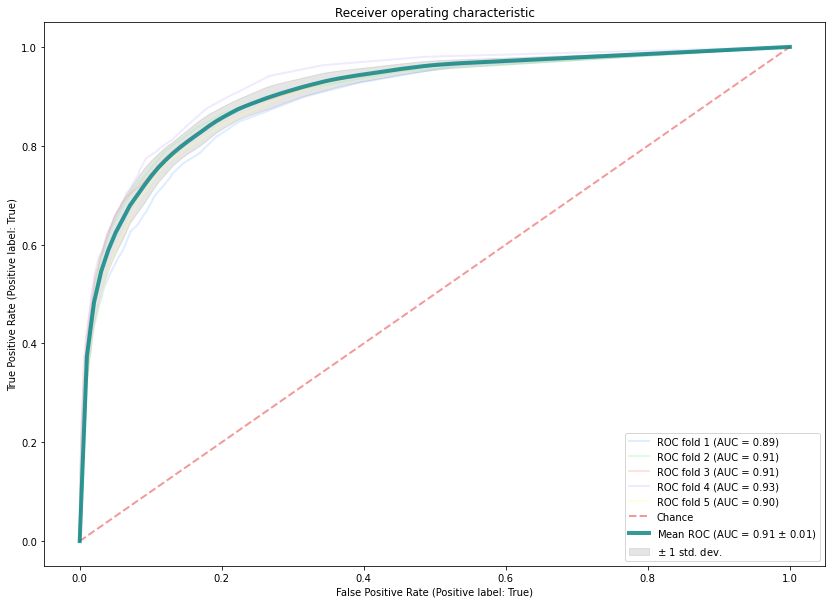

In [11]:
X_np=X.values
y_np=y.values
cv = KFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=[14,10])
mpl.style.use("seaborn-pastel")
for i, (train, test) in enumerate(cv.split(X_np, y_np)):
    rf_best.fit(X_np[train], y_np[train])
    viz = RocCurveDisplay.from_estimator(
        rf_best,
        X_np[test],
        y_np[test],
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=2,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="lightcoral", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="teal",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=4,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",

)
ax.legend(loc="lower right")
plt.show()

tprs_export = pd.DataFrame(tprs).transpose()
tprs_export.columns = ["kf_1", "kf_2", "kf_3", "kf_4", "kf_5"]
tprs_export

roc_curves = pd.concat(
    [
        tprs_export, 
        pd.Series(mean_fpr, name="mean_fpr"),
        pd.Series(mean_tpr, name="mean_tpr"), 
        pd.Series(std_tpr, name="std_tpr"), 
        pd.Series(mean_tpr, name="tprs_upper"),
        pd.Series(mean_tpr, name="tprs_lower")
    ], 
    axis=1
)

aucs_export = pd.DataFrame(aucs).transpose()
aucs_export.columns = ["kf_1", "kf_2", "kf_3", "kf_4", "kf_5"]
aucs_export

auc_values = pd.concat(
    [
        aucs_export,
        pd.Series(mean_auc, name="mean_auc"),
        pd.Series(std_auc, name="std_auc")
    ],
    axis=1
)

In [10]:
ft_imp = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
ft_imp

mean_pPcons124    0.150942
mean_pcons27      0.132384
length            0.117793
mean_gc           0.116668
mean_remap        0.114404
bestTSS           0.112932
bestTSS_inside    0.102770
cov_tfbs          0.088953
cov_pol2          0.063152
dtype: float64

In [11]:
# !pip install seaborn
import seaborn as sns

In [12]:
features_7500_each = pd.concat([features_clean[features_clean['lncRNA'] == True].sample(n=7500), features_clean[features_clean['lncRNA'] == False].sample(n=7500)], axis=0)

In [82]:
np.log(features_7500_each['length'])

192967    5.634790
207354    5.918894
86257     8.087640
1093      5.846439
27116     5.888878
            ...   
117387    7.321189
60373     6.066108
154931    5.513429
31310     3.931826
204445    5.556828
Name: length, Length: 15000, dtype: float64

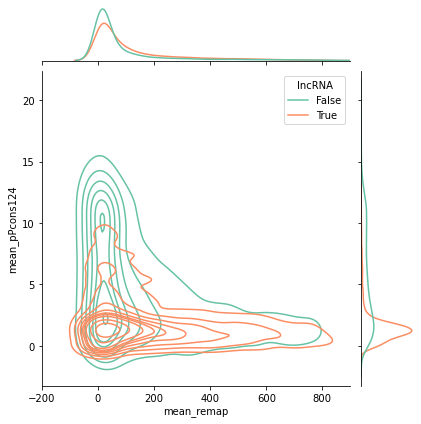

In [14]:
sns.jointplot(x='mean_remap', y='mean_pPcons124', kind='kde', hue='lncRNA', xlim=(-200,900), data=features_7500_each, palette='Set2')

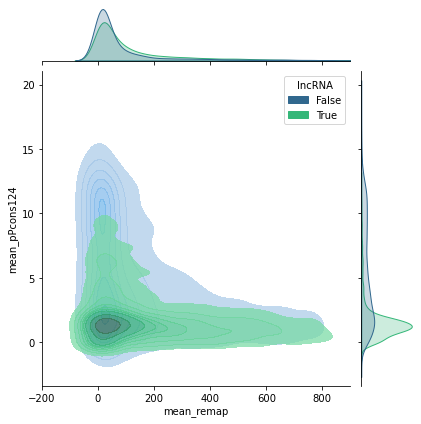

In [90]:
sns.jointplot(x='mean_remap', y='mean_pPcons124', kind='kde', xlim=(-200,900), data=features_7500_each, hue='lncRNA', fill=True, joint_kws={'alpha': 0.7}, palette='viridis')

In [56]:
# !pip install plotly
import plotly.express as px
import plotly.graph_objects as go

In [87]:
fig = px.scatter_3d(
    features_7500_each,
    x='mean_remap',
    y='mean_pPcons124',
    z='bestTSS',
    size=np.log(features_7500_each['length']),
    color='lncRNA',
    hover_data=['name'],
    size_max=5
)
fig.update_layout(scene_zaxis_type='log', scene_yaxis_type='log', scene_xaxis_type='log')
fig.show()

<AxesSubplot:>

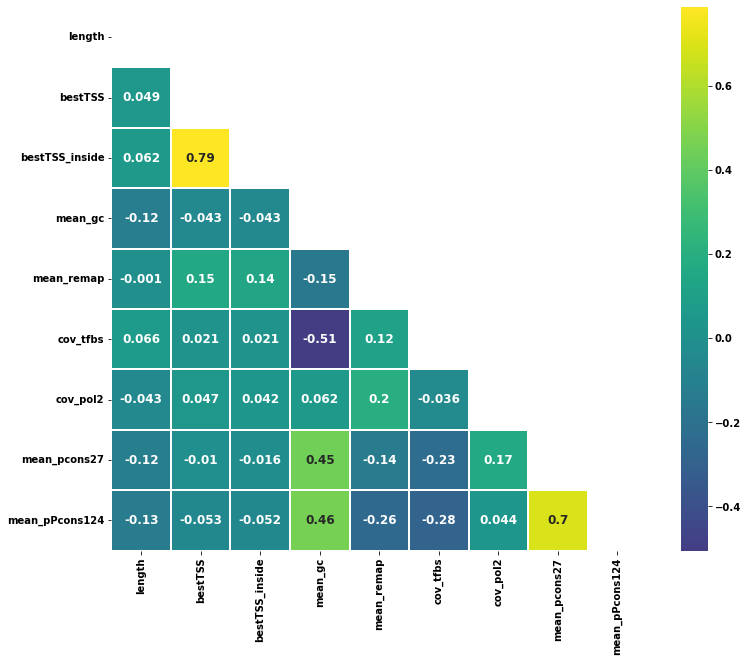

In [53]:
import matplotlib.pyplot as plt
import matplotlib

ft_cor = X.corr().round(3)
fig, ax = plt.subplots(figsize=(12, 10))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

mask = np.zeros_like(ft_cor)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    ft_cor, 
    ax=ax, 
    annot=True, 
    cmap='viridis',
    linewidth=2,
    annot_kws={
        'fontsize': 'large',
        'weight': 'semibold'
    },
    mask=mask,
    center=0
)


In [44]:
ft_cor*100

,length,bestTSS,bestTSS_inside,mean_gc,mean_remap,cov_tfbs,cov_pol2,mean_pcons27,mean_pPcons124
length,100.0,4.9,6.2,-12.2,-0.1,6.6,-4.3,-11.5,-13.0
bestTSS,4.9,100.0,78.8,-4.3,15.5,2.1,4.7,-1.0,-5.3
bestTSS_inside,6.2,78.8,100.0,-4.3,13.8,2.1,4.2,-1.6,-5.2
mean_gc,-12.2,-4.3,-4.3,100.0,-15.2,-50.5,6.2,44.8,45.5
mean_remap,-0.1,15.5,13.8,-15.2,100.0,11.7,19.8,-13.6,-25.7
cov_tfbs,6.6,2.1,2.1,-50.5,11.7,100.0,-3.6,-22.9,-28.3
cov_pol2,-4.3,4.7,4.2,6.2,19.8,-3.6,100.0,16.5,4.4
mean_pcons27,-11.5,-1.0,-1.6,44.8,-13.6,-22.9,16.5,100.0,70.1
mean_pPcons124,-13.0,-5.3,-5.2,45.5,-25.7,-28.3,4.4,70.1,100.0


## Exported Model without 'cov_me3' and 'pPcons27'
pPcons27 & pPcons124 are highly correlated, so I am discarding pPcons27 since I have another algorithm for 27 insect conservation pcons27. Alhtough it is highly correlated with pPcons124, it is less than pPcons27.
I am also dropping cov_me3 since it doesn't help in the outcome of the classifier.
This was done for simplicity, I have to remember to remove these querys from the get-feature.sh script

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def score_rf_model(X, y, kf):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print("accuracy:", np.mean(accuracy_scores))
    print("precision:", np.mean(precision_scores))
    print("recall:", np.mean(recall_scores))
    print("f1:", np.mean(f1_scores))

In [20]:
X_best_ft = features_clean[["length", "bestTSS", "bestTSS_inside", "mean_gc", "mean_remap", "cov_tfbs", "cov_pol2", "mean_pcons27", "mean_pPcons124"]]
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_best_ft, y)
score_rf_model(X_best_ft, y, kf)

accuracy: 0.9847078091680694
precision: 0.9288440932947596
recall: 0.572376514934079
f1: 0.7082048955689554


In [22]:
rf_final = RandomForestClassifier(n_jobs=-1, random_state=15)
rf_final.fit(X, y)
score_rf_model(X, y, kf)

accuracy: 0.9845638623735798
precision: 0.9237849164408882
recall: 0.5711834946606069
f1: 0.7058371391535179


### Final shape of X features:

In [23]:
X.columns

Index(['length', 'bestTSS', 'bestTSS_inside', 'mean_gc', 'mean_remap',
       'cov_tfbs', 'cov_pol2', 'mean_pcons27', 'mean_pPcons124'],
      dtype='object')

### Final model metrics

In [24]:
def score_model(X, y, model, splits):
    kf = KFold(n_splits=splits, shuffle=True, random_state=15)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    tn = []
    fp = []
    fn = []
    tp = []
    cm_y_true = []
    cm_y_pred = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)

        # Compute standard scores and append
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Compute confusion matrix and append
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        tn.append(cm.ravel()[0]) 
        fp.append(cm.ravel()[1])
        fn.append(cm.ravel()[2])
        tp.append(cm.ravel()[3])

        cm_y_true.append(y_test)
        cm_y_pred.append(y_pred)

    # Average standard metrics
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    print("accuracy:", round(avg_accuracy, ndigits=3))
    print("precision:", round(avg_precision, ndigits=3))
    print("recall:", round(avg_recall, ndigits=3))
    print("f1:", round(avg_f1, ndigits=3))

    sc = {
        'accuracy' : accuracy_scores,
        'precision' : precision_scores,
        'recall' : recall_scores,
        'f1' : f1_scores,
    }

    scores = pd.DataFrame(data=sc)
    
    plt.boxplot(scores, labels=scores.columns)
    
    # Average confusion matrix
    cm_y_true = np.concatenate(cm_y_true)
    cm_y_pred = np.concatenate(cm_y_pred)

    skplt.metrics.plot_confusion_matrix(cm_y_true, cm_y_pred, normalize='true')
    plt.show()
    # avg_cm = np.array([[np.mean(tn), np.mean(fp)], [np.mean(fn), np.mean(tp)]], dtype=int)
    # ConfusionMatrixDisplay(avg_cm).plot()
    
    return scores, cm

accuracy: 0.985
precision: 0.928
recall: 0.572
f1: 0.708


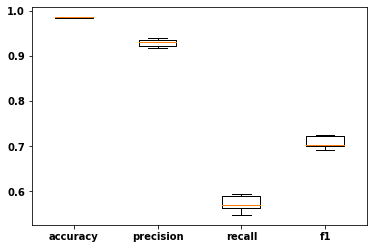

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


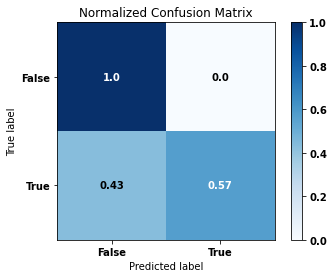

In [25]:
metrics, cm = score_model(X, y, rf_final, 5)

In [26]:
metrics

,accuracy,precision,recall,f1
0,0.984843,0.935743,0.588384,0.722481
1,0.984928,0.916122,0.569783,0.702590
2,0.985288,0.930683,0.592857,0.724316
3,0.984018,0.921218,0.563263,0.699083
4,0.984420,0.938567,0.547445,0.691534


In [100]:
pd.DataFrame(cm).to_csv('rf_norm_conf_matrix.csv')
metrics.transpose().to_csv('rf_metrics.csv', header=True)

### Curve functions:

In [19]:
def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    """
    Draw a Cross Validated ROC Curve.
    Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    Example largely taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    ## Added this code so the function would export the values to two pandas dataframes:
    # roc_curves
    # auc_values
    tprs_export = pd.DataFrame(tprs).transpose()
    tprs_export.columns = ["kf_1", "kf_2", "kf_3", "kf_4", "kf_5"]
    tprs_export

    roc_curves = pd.concat(
        [
            tprs_export, 
            pd.Series(mean_fpr, name="mean_fpr"),
            pd.Series(mean_tpr, name="mean_tpr"), 
            pd.Series(std_tpr, name="std_tpr"), 
            pd.Series(tprs_upper, name="tprs_upper"),
            pd.Series(tprs_lower, name="tprs_lower")
        ], 
        axis=1
    )

    aucs_export = pd.DataFrame(aucs).transpose()
    aucs_export.columns = ["kf_1", "kf_2", "kf_3", "kf_4", "kf_5"]
    aucs_export

    auc_values = pd.concat(
        [
            aucs_export,
            pd.Series(mean_auc, name="mean_auc"),
            pd.Series(std_auc, name="std_auc")
        ],
        axis=1
    )

    return roc_curves, auc_values




def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
        
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []
    aucs = []
    precs = []
    recs = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute PR curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])

        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                label='PR fold %d (AUC = %0.2f)' % (i+1, average_precision_score(y.iloc[test], probas_[:, 1])))
        
        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        aucs.append(average_precision_score(y.iloc[test], probas_[:, 1]))

        precs.append(precision)
        recs.append(recall)

        i += 1


    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    
    plt.plot(recall, precision, color='b',
            label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
            lw=2, alpha=.8)

    prec_export = pd.DataFrame(precs).transpose()
    rec_export = pd.DataFrame(recs).transpose()
    prec_export.columns = ["prec_kf_1", "prec_kf_2", "prec_kf_3", "prec_kf_4", "prec_kf_5"]
    rec_export.columns = ["rec_kf_1", "rec_kf_2", "rec_kf_3", "rec_kf_4", "rec_kf_5"]

    pr_curves = pd.concat(
        [
            prec_export,
            pd.Series(precision, name = 'mean_precision'),
            rec_export,
            pd.Series(recall, name = 'mean_recall')
        ], 
        axis=1
    )

    aucs_export = pd.DataFrame(aucs).transpose()
    aucs_export.columns = ["kf_1", "kf_2", "kf_3", "kf_4", "kf_5"]
    aucs_export

    mean_auc = np.mean(aucs, axis=0)
    std_auc = np.std(aucs, axis=0)

    auc_values = pd.concat(
        [
            aucs_export,
            pd.Series(mean_auc, name="mean_auc"),
            pd.Series(std_auc, name="std_auc")
        ],
        axis=1
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return pr_curves, auc_values

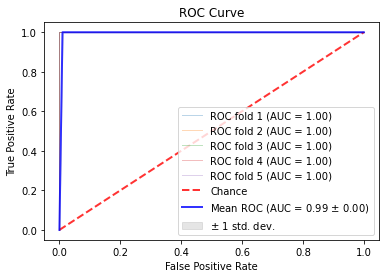

In [21]:
cv = KFold(n_splits=5, shuffle=True, random_state=15)
roc_curves, roc_auc_values = draw_cv_roc_curve(rf_gs, cv, X, y)

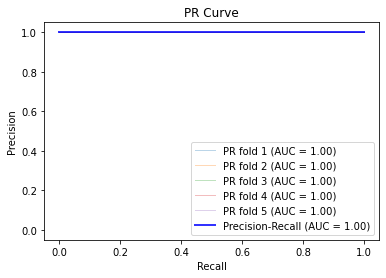

In [22]:
cv = KFold(n_splits=5, shuffle=True, random_state=15)
pr_curves, pr_auc_values = draw_cv_pr_curve(rf_gs, cv, X, y)

In [72]:
roc_curves.round(5).to_csv('rf_roc_curves.csv')
auc_values.round(5).to_csv('rf_auc_values.csv')
pr_curves.round(5).to_csv('rf_pr_curves.csv')
pr_auc_values.round(5).to_csv('rf_pr_auc_values.csv')

In [ ]:
modelname = 'rf_dm6_lncrna_classifier.model'
pickle.dump(rf_final, open(modelname, 'wb'))